In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Read data

In [17]:
reviews = pd.read_csv(r"..\data\amazon_reviews_sample.csv")
reviews = reviews.drop("Unnamed: 0", axis=1)
reviews.head()

,score,review
0,1,Stuning even for the non-gamer: This sound tr...
1,1,The best soundtrack ever to anything.: I'm re...
2,1,Amazing!: This soundtrack is my favorite musi...
3,1,Excellent Soundtrack: I truly like this sound...
4,1,"Remember, Pull Your Jaw Off The Floor After H..."


## Check the counts of positive and negative reviews

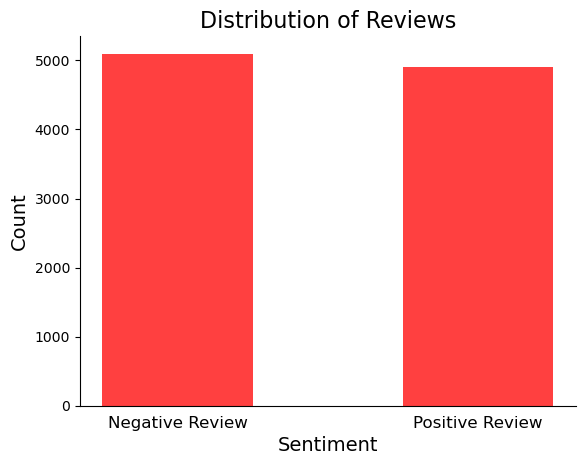

In [18]:
# Show distribution of target
g = sns.histplot(reviews.score, 
                 discrete= True, 
                 shrink=.5, 
                 color = 'red', 
                 edgecolor='None')

g.set_xticks([0, 1]) 
g.set_xticklabels(['Negative Review', 'Positive Review'], fontsize=12)
g.set_ylabel("Count", fontsize=14)
g.set_xlabel("Sentiment", fontsize=14)
plt.title('Distribution of Reviews', fontsize=16)
g.tick_params(bottom=False)
sns.despine(right=True, top=True)
plt.show()

## Word cloud and feature creation

* Build a word cloud using only the top 100 positive reviews.
* Create a new feature for the length of each review and add that new feature to the dataset.

### Word Cloud

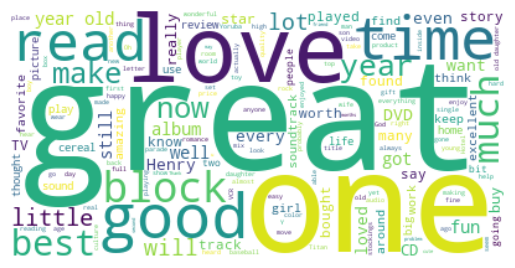

In [19]:
# Concatenating the descriptions of the top 100 positive reviews.
positives = reviews[reviews["score"] ==1]
positive_reviews = positives.iloc[0:100].review.str.cat() 

# Create and generate a word cloud image
my_stop_words = STOPWORDS.update(["movie", "movies", "film", "films", "book", "books", "watch", "game", "games", "br", "theatre", "cinema", "music", "song", "songs"])
cloud_positives = WordCloud(background_color='white').generate(positive_reviews)
 
# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation='bilinear') 
plt.axis("off")
plt.show()

### Calculating length of each review

In [20]:
# Tokenize each item in the review column
word_tokens = [word_tokenize(review) for review in reviews.review]

# Create an empty list to store the length of the reviews
len_tokens = []

# Iterate over the word_tokens list and determine the length of each item
for i in range(len(word_tokens)):
     len_tokens.append(len(word_tokens[i]))

# Create a new feature for the lengh of each review
reviews['n_words'] = len_tokens 
reviews.head()

,score,review,n_words
0,1,Stuning even for the non-gamer: This sound tr...,87
1,1,The best soundtrack ever to anything.: I'm re...,109
2,1,Amazing!: This soundtrack is my favorite musi...,165
3,1,Excellent Soundtrack: I truly like this sound...,145
4,1,"Remember, Pull Your Jaw Off The Floor After H...",109


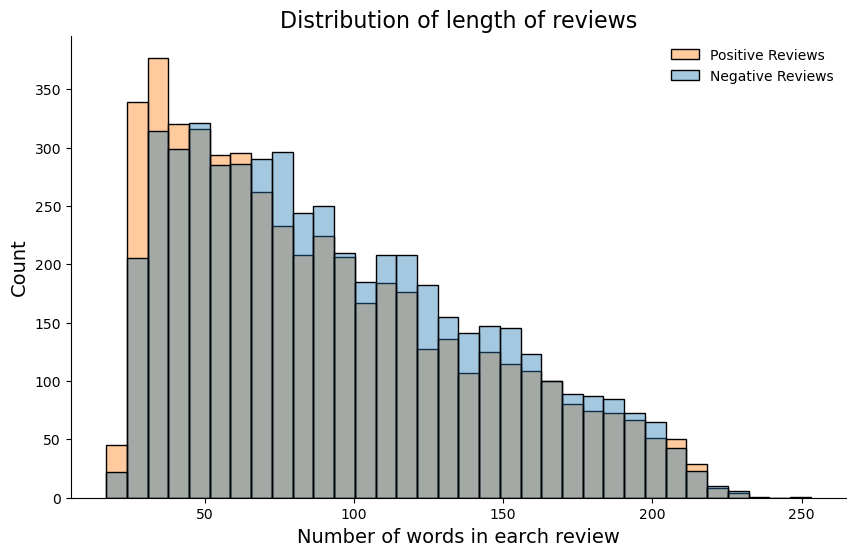

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data=reviews, x='n_words', hue='score', alpha=0.4)
plt.title('Distribution of length of reviews', fontsize=16)
plt.xlabel('Number of words in earch review', fontsize=14)
plt.ylabel('Count', fontsize=14)
#plt.grid(True)
sns.despine(right=True, top=True)
plt.legend(["Positive Reviews", "Negative Reviews"], frameon=False)
plt.show()

In [22]:
label = reviews.score
data = reviews.drop('score', axis=1)

## Building a vectorizer

* Build a TfIDf transformation of the review column in the reviews dataset: specify the n-grams, stop words, the pattern of tokens and the size of the vocabulary arguments.
* Train a classifier to predict the sentiment of a review.

In [23]:
# Define the set of stop words
my_stop_words = ENGLISH_STOP_WORDS.union(["movie", "movies", "film", "films", "book", "books", "watch", "game", "games", "br", "theatre", "cinema", "music", "song", "songs"])

# Build the vectorizer
# CountVectorizer
# TfidfVectorizer
review_vect = TfidfVectorizer(max_features=200, 
                              token_pattern=r'\b[^\d\W][^\d\W]+\b',
                              stop_words=list(my_stop_words))

review_vect.fit(reviews.review)

# Create the bow representation
reviews_bow = review_vect.transform(reviews.review)

# Create the data frame
reviews_transformed = pd.DataFrame(reviews_bow.toarray(), columns=review_vect.get_feature_names_out())
print(reviews_transformed.head())

   able  acting  action  actually  ago  album   amazing  amazon  author  \
0   0.0     0.0     0.0       0.0  0.0    0.0  0.000000     0.0     0.0   
1   0.0     0.0     0.0       0.0  0.0    0.0  0.000000     0.0     0.0   
2   0.0     0.0     0.0       0.0  0.0    0.0  0.438057     0.0     0.0   
3   0.0     0.0     0.0       0.0  0.0    0.0  0.000000     0.0     0.0   
4   0.0     0.0     0.0       0.0  0.0    0.0  0.000000     0.0     0.0   

       away  ...      work  works  world  worst    worth  writing  written  \
0  0.378592  ...  0.000000    0.0    0.0    0.0  0.00000      0.0      0.0   
1  0.000000  ...  0.000000    0.0    0.0    0.0  0.23271      0.0      0.0   
2  0.000000  ...  0.163579    0.0    0.0    0.0  0.18321      0.0      0.0   
3  0.000000  ...  0.000000    0.0    0.0    0.0  0.00000      0.0      0.0   
4  0.000000  ...  0.000000    0.0    0.0    0.0  0.00000      0.0      0.0   

   wrong  year     years  
0    0.0   0.0  0.000000  
1    0.0   0.0  0.221548  

## Building a classifier

In [24]:
reviews_transformed["label"] = label
reviews_transformed["n_words"] = data["n_words"]

# Define the vector of targets and matrix of features
y = reviews_transformed.label
X = reviews_transformed.drop('label', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)

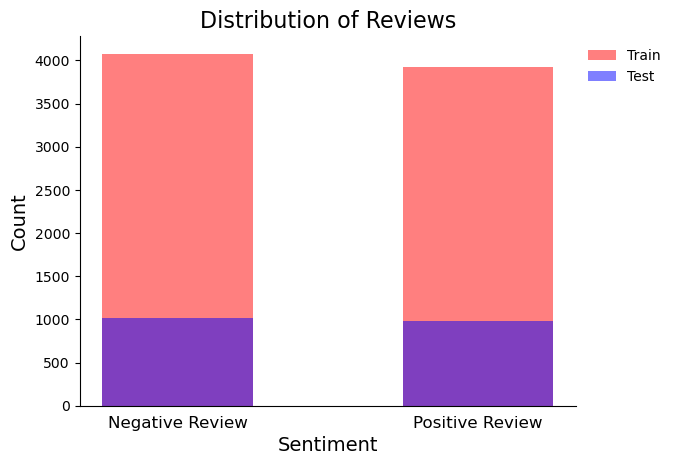

In [26]:
# Show distribution of target
g = sns.histplot(y_train, discrete= True, shrink=.5, color = 'red', alpha = 0.5, edgecolor='None')
g.set_xticks([0, 1]) 
g.set_xticklabels(['Negative Review', 'Positive Review'], fontsize=12)
g = sns.histplot(y_test, discrete= True, shrink=.5, color="blue", alpha = 0.5, edgecolor='None')
sns.despine(right=True, top=True)
g.set_xlabel("Sentiment", fontsize=14)
g.set_ylabel("Count", fontsize=14)
plt.legend(["Train", "Test"], frameon=False)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.title('Distribution of Reviews', fontsize=16)
g.tick_params(bottom=False)
plt.show()

In [27]:
# Build steps for the pipeline
steps = [("scaler", StandardScaler()),
         ("log_reg", LogisticRegression())]

# Create the parameter space
parameters = {
    "log_reg__C": np.linspace(0.1, 1, 10),
    }

# Create the pipeline
pipeline = Pipeline(steps)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters, scoring="accuracy")

# Fit to the training data
cv.fit(X_train, y_train)

print("Best parameters: ", cv.best_params_)
print("Accuracy of logistic regression on training data: {:.2f}".format(cv.best_score_))

Best parameters:  {'log_reg__C': 0.1}
Accuracy of logistic regression on training data: 0.79


In [28]:
# Make predictions on the test set
y_pred = cv.predict(X_test)
print("Accuracy of logistic regression on testing data: {:.2f}".format(accuracy_score(y_test, y_pred)))

Accuracy of logistic regression on testing data: 0.79


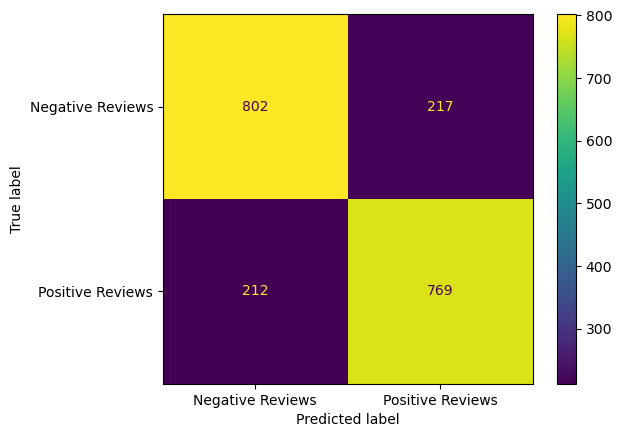

                  precision    recall  f1-score   support

Negative Reviews       0.79      0.79      0.79      1019
Positive Reviews       0.78      0.78      0.78       981

        accuracy                           0.79      2000
       macro avg       0.79      0.79      0.79      2000
    weighted avg       0.79      0.79      0.79      2000



In [29]:
cm = confusion_matrix(y_test, y_pred, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=["Negative Reviews", "Positive Reviews"])
disp.plot()
plt.show()

print(classification_report(y_test, y_pred, 
                            target_names=["Negative Reviews", "Positive Reviews"]))

In [30]:
# Predict the probability of the 0 class
prob_0 = cv.predict_proba(X_test)[:, 0]
# Predict the probability of the 1 class
prob_1 = cv.predict_proba(X_test)[:, 1]

print("First 10 predicted probabilities of class 0: ", prob_0[:5])
print("First 10 predicted probabilities of class 1: ", prob_1[:5]) 

First 10 predicted probabilities of class 0:  [0.11429921 0.16391984 0.56408838 0.72534273 0.35840649]
First 10 predicted probabilities of class 1:  [0.88570079 0.83608016 0.43591162 0.27465727 0.64159351]
